# 0 Imports

In [47]:
import numpy          as np
import pandas         as pd
import seaborn        as sns
import plotly.express as px

import datetime
import warnings
import inflection

from datetime             import datetime
from matplotlib           import pyplot as plt
from matplotlib.gridspec  import GridSpec
from IPython.display      import Image
from IPython.core.display import HTML

from sklearn.cluster     import KMeans
from sklearn.metrics     import silhouette_score  
from yellowbrick.cluster import KElbowVisualizer

warnings.filterwarnings( 'ignore' )

## 0.1 Funções auxiliares

In [48]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [14, 5]
    plt.rcParams['font.size'] = 18
    sns.set_palette("Reds") 
    
    display(HTML( '<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [49]:
jupyter_settings()

## 0.2 Carregamento dos dados

In [50]:
df_raw = pd.read_csv('../inputs/data.csv', encoding= 'unicode_escape')

In [51]:
df_raw.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
407334,C571861,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,-1,10/19/2011 13:43,3.95,16670.0,United Kingdom
98662,544684,22714,CARD BIRTHDAY COWBOY,2,2/22/2011 16:32,0.83,NaN,United Kingdom
120313,546652,22668,PINK BABY BUNTING,1,3/15/2011 14:18,5.79,NaN,United Kingdom
244157,558475,21931,JUMBO STORAGE BAG SUKI,2,6/29/2011 15:58,4.13,NaN,United Kingdom
18954,537823,22804,CANDLEHOLDER PINK HANGING HEART,1,12/8/2010 14:25,5.91,NaN,United Kingdom
122415,546871,22621,TRADITIONAL KNITTING NANCY,12,3/17/2011 16:10,1.45,16746.0,United Kingdom
261732,559884,23206,LUNCH BAG APPLE DESIGN,10,7/13/2011 11:34,1.65,16843.0,United Kingdom
375915,569487,22596,CHRISTMAS STAR WISH LIST CHALKBOARD,24,10/4/2011 12:55,1.25,13351.0,United Kingdom
309042,564061,21877,HOME SWEET HOME MUG,1,8/22/2011 14:38,1.25,14505.0,United Kingdom
534014,581129,23319,BOX OF 6 MINI 50'S CRACKERS,6,12/7/2011 12:48,2.49,15498.0,United Kingdom


# 1 Descrição dos dados

In [52]:
df1 = df_raw.copy()

## 1.1 Renomeando colunas

In [53]:
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, df1.columns))

#rename
df1.columns = cols_new

## 1.2 Dimensão dos dados

In [54]:
print('Núm de Linhas: {}'.format(df1.shape[0]))
print('Núm de Colunas: {}'.format(df1.shape[1]))

Núm de Linhas: 541909
Núm de Colunas: 8


## 1.3 Tipo dos dados

In [55]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Checagem de valores nulos

In [56]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Preenchimento de nulos

In [57]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Percentual de dados removidos: {:.2f}%'.format((1 - (df1.shape[0] / df_raw.shape[0]))*100))
print(df1.shape)

Percentual de dados removidos: 24.93%
(406829, 8)


## 1.6 Mudando tipo dos dados

In [58]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], infer_datetime_format=True).dt.date.astype('datetime64')

# customer_id 
df1['customer_id'] = df1['customer_id'].astype('int64').astype('object')

In [59]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id             object
country                 object
dtype: object

## 1.7 Análise descritiva

# 2 Feature engineering

In [60]:
df2 = df1.copy()

## 2.1 Criação de novas variáveis

In [61]:
# df de referência 
df_ref = df2[['customer_id']].drop_duplicates(ignore_index=True)

# revenue = quantity * price
df2['revenue'] = df2['quantity'] * df2['unit_price']

# monetary
df_monetary = df2.groupby('customer_id')['revenue'].sum().reset_index()

# recency
df_recency = df2.groupby('customer_id')['invoice_date'].max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days

# frequency
df_frequency = df2.groupby('customer_id')['invoice_no'].nunique().reset_index()

# join
c_id = 'customer_id'
df_ref = df_ref.merge(df_monetary, on=c_id, how='left').merge(df_recency, on=c_id, how='left').merge(df_frequency, on=c_id, how='left')

In [62]:
df_ref.shape

(4372, 5)

In [63]:
df_ref.head().T

,0,1,2,3,4
customer_id,17850,13047,12583,13748,15100
revenue,5288.63,3079.1,7187.34,948.25,635.1
invoice_date,2011-02-10 00:00:00,2011-11-08 00:00:00,2011-12-07 00:00:00,2011-09-05 00:00:00,2011-01-13 00:00:00
recency_days,302,31,2,95,330
invoice_no,35,18,18,5,6


# 3 Filtragem dos dados

In [64]:
df3 = df_ref.copy()

## 3.1 Filtragem das linhas

## 3.2 Filtragem das colunas

# 4. Análise exploratória de dados (EDA)

In [65]:
df4 = df3.copy()

# 5 Preparação dos dados

In [66]:
df5 = df4.copy()

# 6 Seleção de variáveis

In [67]:
df6 = df5.copy()

# 7 Otimização dos hiperparâmetros

In [68]:
df7 = df6.copy()

In [69]:
X = df7[['revenue', 'recency_days', 'invoice_no']]

In [70]:
clusters = [2, 3, 4, 5, 6]

## 7.1 Within-Cluster Sum of Square (WSS)

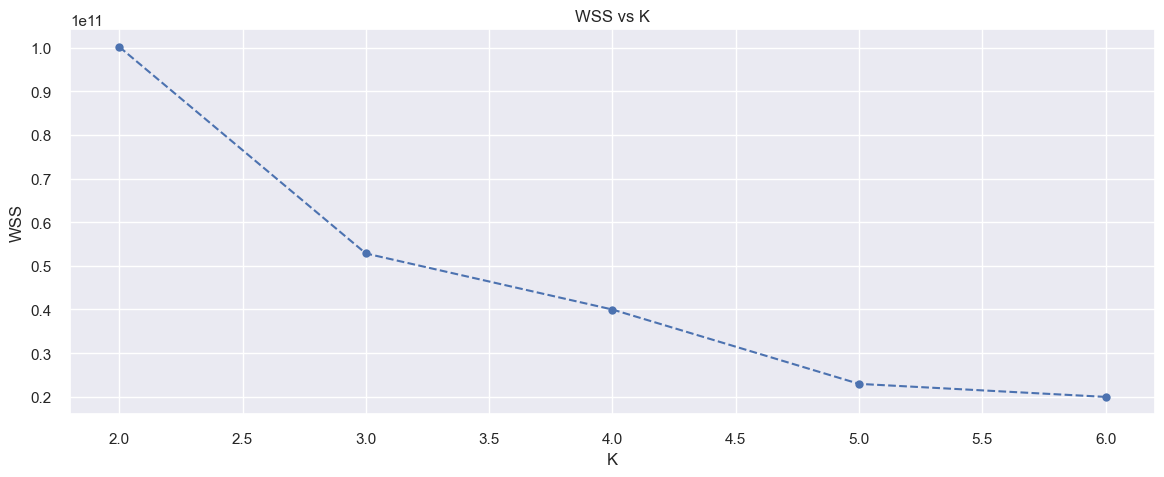

In [71]:
wss = []
for k in clusters:
    #model definition
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit(X)
    
    #validation
    wss.append(kmeans.inertia_)
    
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('WSS')
plt.title('WSS vs K')
plt.show()

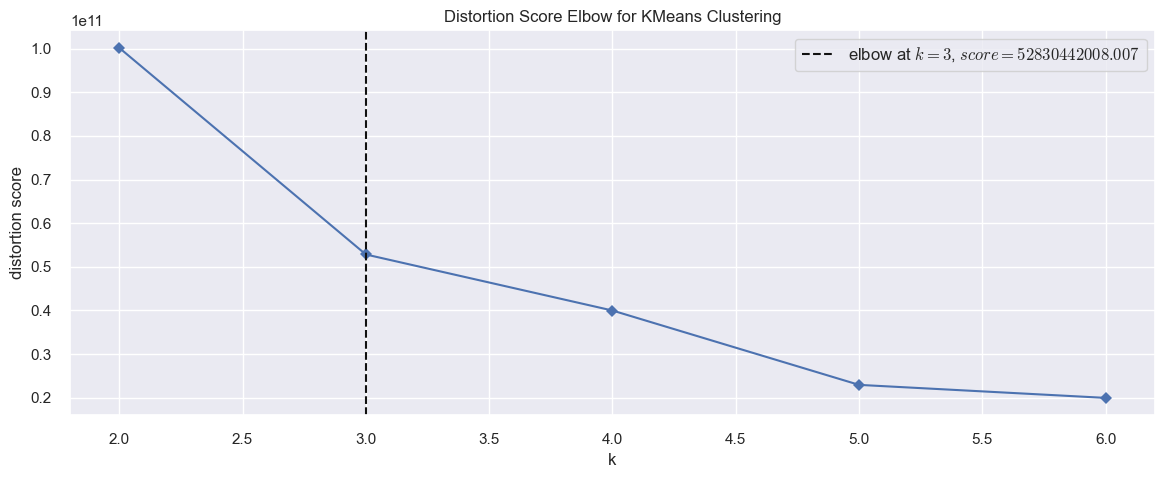

In [72]:
kmeans = KElbowVisualizer(KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2 Silhouette Score

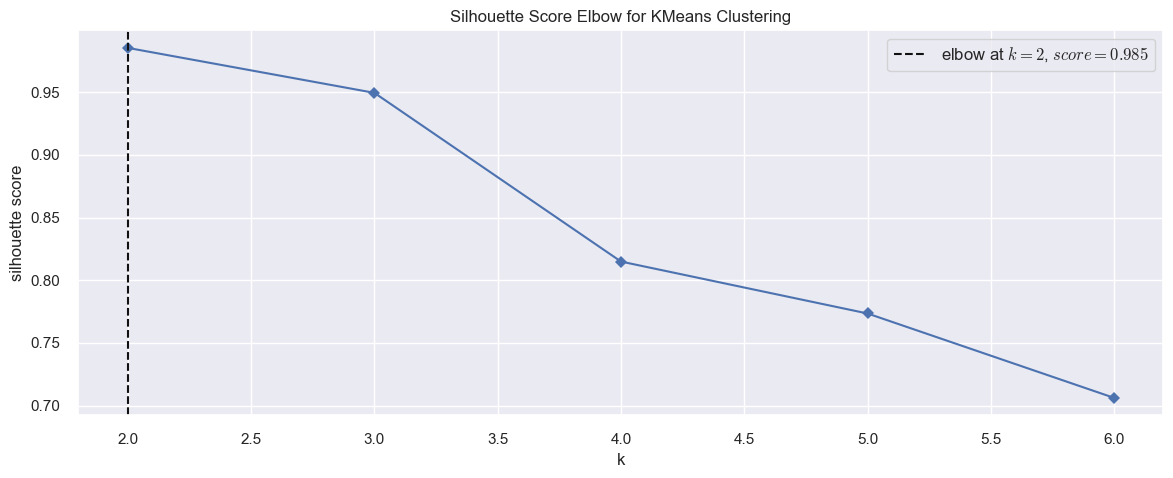

In [73]:
kmeans = KElbowVisualizer(KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42), k=clusters, metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show();

# 8 Machine learning

## 8.1 K-Means

In [74]:
k = 3
#model definition
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

#model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

## 8.2 Validação dos clusters

In [75]:
# WSS (Within-cluster Sum of Square) 
print('WSS Value: {}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS Value: {}'.format(silhouette_score(X, labels)))

WSS Value: 52830442008.00695
SS Value: 0.9494677566681542


# 9 Análise dos clusters

In [76]:
df9 = df7.drop('invoice_date', axis=1).copy()
df9['cluster'] = labels

## 9.1 Inspeção visual

In [77]:
fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='revenue', color='cluster')
fig.show()

## 9.2 Perfil dos clusters

In [78]:
# Numeros de clientes
df_cluster = df9.groupby('cluster')['customer_id'].count().reset_index()
df_cluster['perc_customer'] = round((df_cluster['customer_id'] / df_cluster['customer_id'].sum())*100, 2)

# Média de faturamento
df_avg_revenue = df9.groupby('cluster')['revenue'].mean().round(2).reset_index()
df_cluster = pd.merge(df_cluster, df_avg_revenue, how='inner', on='cluster')

# Média de recencia
df_avg_recency = df9.groupby('cluster')['recency_days'].mean().round(2).reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

# Média de frequencia
df_avg_frequency = df9.groupby('cluster')['invoice_no'].mean().round(2).reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how='inner', on='cluster')

df_cluster.sort_values('customer_id')

,cluster,customer_id,perc_customer,revenue,recency_days,invoice_no
1,1,6,0.14,182181.98,7.17,89.00
2,2,31,0.71,40543.52,13.29,53.29
0,0,4335,99.15,1372.58,92.26,4.61


### Cluster 01: Candidato ao programa Insider
- Número de clientes: 6 (0,14% do total da base)
- Recência média: 7 dias
- Compras média no período: 89 compras
- Receita média: $182.181


### Cluster 02:
- Número de clientes: 31 (0,71% do total da base)
- Recência média: 13 dias
- Compras média no período: 53 compras
- Receita média: $40.543

### Cluster 03:
- Número de clientes: 4335 (99,15% do total da base)
- Recência média: 92 dias
- Compras média no período: 4 compras
- Receita média: $1.372

# 10 Deployment do modelo em produção